<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/ImageCorruptionMNIST_masknoise05_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook for reproducing the third example in Section 3.3 (data inputation and denoising)**

In [1]:
import os
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     - 8.0MB 1.4MB/s


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [4]:
import os

from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

PROJ = "My Drive/BDL2019" 
PROJECT_PATH = os.path.join(ROOT, PROJ)
print(PROJECT_PATH)
if not os.path.isdir(PROJECT_PATH):
  os.makedirs(PROJECT_PATH)

model_dir = os.path.join(PROJECT_PATH, 'model/')
module_dir= os.path.join(PROJECT_PATH, 'modules/')


generator_path   = os.path.join(module_dir, 'GaussianVAEs/July312019/decoder/')
nvp_func_path    = os.path.join(module_dir, 'GaussianVAEs/July312019/nvp/')

print(generator_path)

print(os.path.isdir(generator_path))
print(os.path.isdir(nvp_func_path))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/BDL2019
/content/gdrive/My Drive/BDL2019/modules/GaussianVAEs/July312019/decoder/
True
True


In [5]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
data_dim    = 28*28
data_size   = 1
sigma_n     = 0.1254
hidden_size = 8
n_channels  = 1
seed        = 777


# settings for reconstruction with uncorrupted data
# corr_type   = 'none'
# num_mnist   = 6
# label       = 'uncorrupted'
# noise_level = 0.0
# num_comp    = 2

# settings for reconstrcution with rectangular mask
# corr_type   = 'mask'
# num_mnist   = 6
# label       = 'solidmask'
# noise_level = 0.0
# num_comp    = 5

#settings for reconstruction with sparse mask 
# corr_type   = 'sparse mask'
# num_mnist   = 1
# label       = 'sparse95'
# noise_level = 0.
# num_comp    = 2

# settings for reconstruction with noise
# corr_type   = 'noise'
# num_mnist   = 6
# label       = 'noise05'
# noise_level = 0.5
# num_comp    = 4

# settings for reconstruction with noise and mask
corr_type   = 'noise+mask'
num_mnist   = 6
label       = 'masknoise05_vae'
noise_level = 0.5
num_comp    = 2

In [7]:
minima_path      = os.path.join(PROJECT_PATH, 'minima/%s/'%label)
plot_path        = os.path.join(PROJECT_PATH, 'plots/%s/'%label)

if not os.path.isdir(plot_path):
  os.makedirs(plot_path)
  
if not os.path.isdir(minima_path):
  os.makedirs(minima_path)
  
print(os.path.isdir(plot_path))

True


In [0]:
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
  
  if np.any(mask==None):
    mask=np.ones_like(image)
  mask = np.reshape(mask,(28,28))
  plt.figure()
  #plt.title(title)
  plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
  plt.axis('off')
  #plt.colorbar()
  if save: 
    plt.savefig(directory+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
  
  sigma = np.ones(shape)*sigma_n
  
  if signal_dependent: 
    for ii in range(data_size):
      sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
      sigma[ii][np.where(signal[ii]>threshold)]= sigma_high
      
  data_noise = np.ones_like(sigma)*noise_level
  
  sigma = np.sqrt(sigma**2+data_noise**2)
  
  return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
  
  mask = np.ones((28,28))
  
  if corr_type=='mask':
    
    minx = 10
    maxx = 24
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true*[mask]
    
  elif corr_type=='sparse mask':
    
    mask    = np.ones(data_dim, dtype=int)
    percent = 95
    np.random.seed(seed+2)
    indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
    print('precentage masked:', len(indices)/data_dim)
    mask[indices] =0 
  
    corr_data = x_true*[mask]
    
  elif corr_type=='noise':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    corr_data = x_true+noise
    
  elif corr_type=='noise+mask':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    minx = 14
    maxx = 28
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true+noise
    corr_data = corr_data*[mask]
    
  elif corr_type=='none':
    
    corr_data = x_true
    
  corr_data = np.expand_dims(corr_data,-1)
  
  mask = mask.flatten()
  
  return corr_data, mask

In [0]:
def fwd_pass(generator,nvp,z,mask):
  
  fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']

  gen_z           = tf.boolean_mask(tf.reshape(generator(fwd_z),[data_size,data_dim,n_channels]),mask, axis=1)

  return gen_z


def get_likelihood(generator,nvp,z,sigma,mask):
  
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  sigma           = tf.boolean_mask(sigma,mask, axis=1)

  likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma))

  return likelihood

def get_prior():
  
  return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta):

  likelihood      = get_likelihood(generator,nvp,z,sigma,mask)
  
  prior           = get_prior()
  
  masked_x        = tf.boolean_mask(x,mask, axis=1)
  
  log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta
  
  return log_posterior


def get_recon(generator,nvp, z,sigma,mask):
  
  prob = get_likelihood(generator,nvp, z,sigma,mask)
  
  recon= prob.mean()
  
  return recon

def get_hessian(func, z):
  
  hess             = tf.hessians(func,z)
  hess             = tf.gather(hess, 0)
  
  return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):


  gen_z            = fwd_pass(generator,nvp,z,mask)
  
  sigma            = tf.boolean_mask(sigma,mask, axis=1)

  grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

  grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

  one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

  hess_GN          = one+grad_g2
  
  return hess_GN
  
def compute_covariance(hessian):
  
  cov = tf.linalg.inv(hessian)
  
  cov = (cov+tf.linalg.transpose(cov))*0.5
  
  return cov

In [0]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
  
  ini = np.reshape(initial_value,[data_size,hidden_size])
  
  my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})
  
  pos_def = False

  
  posterior_loss = []
  for lrate, numiter in zip([1e-1,1e-2,1e-3],[10000,5000,3000]):
    print('lrate', lrate)
    for jj in range(numiter):
      if annealing and lrate==1e-1:
        inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
      else:
        inv_T= 1.
      _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
      posterior_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll,r'inverse T', inv_T)
        
  z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})
  
  eig     = my_sess.run(tf.linalg.eigvalsh(hessian),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  if np.all(eig>0.):
    pos_def = True
  
  loss    = ll
  plt.figure()
  plt.plot(posterior_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return z_value, loss, pos_def
  

In [0]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
  
  my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
  my_sess.run(update_mu)
  my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})
  
  samples=[]
  for ii in range(num):
    my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
    samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

def get_gmm_sample(num,x,mymask,noise,my_sess):
  
  samples=[]
  for ii in range(num):
    samples.append(my_sess.run(gmm_recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

In [0]:
def plot_samples(samples, mask, title='samples', filename='samples'):
  plt.figure(figsize=(5,5))
  #plt.title(title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.savefig(plot_path+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plt.figure(figsize=(5,5))
    plt.title('masked'+title)
    for i in range(min(len(samples),16)):
        subplot(4,4,i+1)
        imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
        axis('off')     
    plt.savefig(plot_path+filename+'masked.pdf',bbox_inches='tight')
    plt.show()

In [0]:
def get_random_start_values(num, my_sess):
  result=[]
  for ii in range(num):
    result.append(my_sess.run(get_prior().sample()))
  return result

In [0]:
def get_chi2(sigma,data,mean,masking=True, mask=None,threshold=0.02):
  
  if masking:
    mask = np.reshape(mask,data.shape)
    data = data[np.where(mask==1)]
    mean = mean[np.where(mask==1)]
    sigma= sigma[np.where(mask==1)]
    
  
  low = min(sigma.flatten())
  high= max(sigma.flatten())
  
  chi2_tot = np.sum((data-mean)**2/sigma**2)
  dof_tot  = len(np.squeeze(data))
  
  if corr_type not in ['noise','noise+mask']:
    chi2_low = np.sum((data[np.where(data<=threshold)]-mean[np.where(data<=threshold)])**2/sigma[np.where(data<=threshold)]**2)
    dof_low  = len(np.squeeze(data[np.where(data<=threshold)]))
    chi2_high= np.sum((data[np.where(data>threshold)]-mean[np.where(data>threshold)])**2/sigma[np.where(data>threshold)]**2)
    dof_high = len(np.squeeze(data[np.where(data>threshold)]))
  else:
    chi2_low = None
    dof_low  = None
    chi2_high= None
    dof_high = None
  
  return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

In [0]:
def plot_minima(minima, losses, var):

  plt.figure()
  plt.title('Minimization result')
  plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
  plt.xlabel('# iteration')
  plt.ylabel('loss')
  plt.savefig(plot_path+'minimzation_results_%s.png'%(label),bbox_inches='tight')
  plt.show()
  
  colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
  cmap   = matplotlib.cm.get_cmap('Spectral')
  
  var = np.squeeze(var)
  plt.figure()
  plt.title('value of hidden variables at minima')
  for ii in range(len(minima)):
  
    yerr_= np.sqrt(var[ii])

    plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
  plt.legend(ncol=4, loc=(1.01,0))
  plt.xlabel('# hidden variable')
  plt.ylabel('value')
  plt.savefig(plot_path+'hidden_values_at_minima_%s.png'%(label),bbox_inches='tight')
  plt.show()

In [0]:
def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):

  _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
  _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    H    = exact_hessian[0,nn,nn]
    HGN  = approx_hessian[0,nn,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    title('latent space direction %d'%nn)
    
    Delta   = 0.1
    steps   = 1000
    delta_z = np.zeros((steps,hidden_size))

    delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
    new_ini       = delta_z+minimum

    for ii in range(steps):
      _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(new_ini[ii],axis=0), sigma_corr:noise})
      ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
      losses.append(ll)
     

    

    plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='estimate from exact Hessian')
    #plt.plot(new_ini[:,nn],ll0+HGN*delta_z[:,nn]**2,label='estimate from Gauss-Newton')
    plt.plot(new_ini[:,nn],losses,label='probed posterior', lw=2)
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(min(losses),min(losses)+1.5)

  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_%s.png'%(filename),bbox_inches='tight')
  plt.show()


In [0]:
def get_gmm_parameters(minima, x, noise, mymask, offset):
  mu   =[]
  w    =[]
  sigma=[]
  for ii in range(num_comp):

    # do Laplace approximation around this minimum
    mu+=[minima[ii]]
    sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
    sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]

    # correct weighting of different minima according to El20 procedure, with samples at the maxima and well seperated maxima
    logdet  = sess.run(tf.linalg.logdet(approx_posterior_laplace.covariance()),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    w+=[np.exp(0.5*logdet+logprob+offset)]
    
  print('weights of Gaussian mixtures:', w/np.sum(w))
  mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
  sigma  = np.reshape(np.asarray(sigma),[1,num_comp,hidden_size,hidden_size])
  w      = np.squeeze(np.asarray(w))
                         
  return mu, sigma, w
                                 

In [0]:
def plot_prob_2D_GMM(samples, indices):

    samples = samples[:,0,:]

    samples = np.hstack((np.expand_dims(samples[:,indices[0]],-1),np.expand_dims(samples[:,indices[1]],-1)))

    figure=corner.corner(samples)
    axes = np.array(figure.axes).reshape((2, 2))

    axes[1,0].set_xlabel('latent space variable %d'%indices[0])
    axes[1,0].set_ylabel('latent space variable %d'%indices[1])
    plt.savefig(plot_path+'posterior_contour_GMM_%s_latent_space_dir_%d_%d.png'%(label,indices[0],indices[1]),bbox_inches='tight')
    plt.show()
    
  

In [19]:
tf.reset_default_graph()


sigma_corr  = tf.placeholder_with_default(np.ones([data_size,data_dim,n_channels], dtype='float32')*sigma_n,shape=[data_size,data_dim,n_channels])
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])
input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)

inverse_T   = tf.placeholder_with_default(1., shape=[])
lr          = tf.placeholder_with_default(0.001,shape=[])

generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_func_path, trainable=False)

MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))

nlPost_MAP  = get_log_posterior(MAP, input_data, generator,nvp_funcs, sigma_corr,mask, inverse_T)
loss_MAP    = -tf.reduce_mean(nlPost_MAP)

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)

opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask)

hessian     = get_hessian(-nlPost_MAP,MAP)

GN_hessian  = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)

ini_val  = np.ones((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((data_size,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float32)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update_mu          = mu_new.assign(MAP)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
update_TriL        = sigma_new_t2.assign(tf.linalg.cholesky(covariance))

posterior_sample   = approx_posterior_laplace.sample()

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask)

ini_val2    = np.ones((data_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((data_size,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
w_positive    = tf.math.softplus(w_gmm)
w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

mu_ini        = tf.placeholder_with_default(tf.zeros([data_size,num_comp,hidden_size]),shape=[data_size,num_comp,hidden_size])
sigma_ini     = tf.placeholder_with_default(tf.ones([data_size,num_comp,hidden_size, hidden_size]),shape=[data_size,num_comp,hidden_size, hidden_size])
w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_w      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_ini)))
update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_ini, transform=softplus_inverse)))

gmm_sample    = gmm.sample()
gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


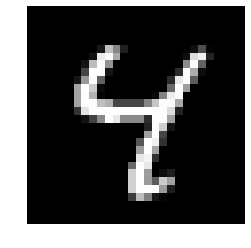

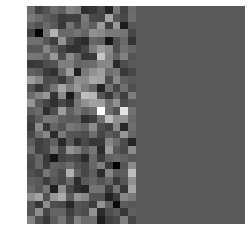

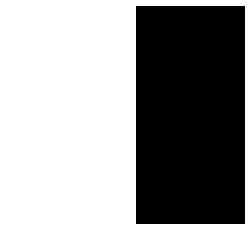

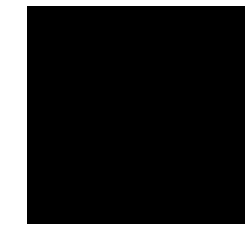

progress in % 0.0
lrate 0.1
iter 0 loss 91.97388 inverse T 0.2
iter 1000 loss 72.06501 inverse T 0.2
iter 2000 loss 71.83991 inverse T 0.2
iter 3000 loss 71.82623 inverse T 0.2
iter 4000 loss 102.800125 inverse T 0.3
iter 5000 loss 102.71433 inverse T 0.3
iter 6000 loss 102.76501 inverse T 0.3
iter 7000 loss 134.69724 inverse T 0.4
iter 8000 loss 134.63145 inverse T 0.4
iter 9000 loss 165.40483 inverse T 0.5
lrate 0.01
iter 0 loss 319.54068 inverse T 1.0
iter 1000 loss 318.88873 inverse T 1.0
iter 2000 loss 318.88123 inverse T 1.0
iter 3000 loss 318.8824 inverse T 1.0
iter 4000 loss 318.88028 inverse T 1.0
lrate 0.001
iter 0 loss 318.88 inverse T 1.0
iter 1000 loss 318.87646 inverse T 1.0
iter 2000 loss 318.87604 inverse T 1.0


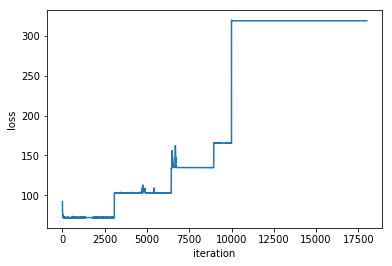

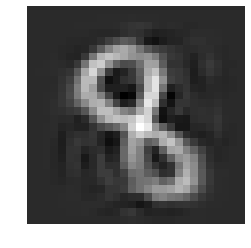

[[ 0.32956508 -1.0698962  -0.70623827  1.5688784  -1.0387864  -0.49123213
  -1.8922956  -0.07418925]]
hessian postive definite
progress in % 10.0
lrate 0.1
iter 0 loss 98.98505 inverse T 0.2
iter 1000 loss 69.20092 inverse T 0.2
iter 2000 loss 69.27668 inverse T 0.2
iter 3000 loss 69.25417 inverse T 0.2
iter 4000 loss 99.455154 inverse T 0.3
iter 5000 loss 99.472305 inverse T 0.3
iter 6000 loss 99.42824 inverse T 0.3
iter 7000 loss 129.77971 inverse T 0.4
iter 8000 loss 129.51732 inverse T 0.4
iter 9000 loss 159.78346 inverse T 0.5
lrate 0.01
iter 0 loss 309.4723 inverse T 1.0
iter 1000 loss 308.6921 inverse T 1.0
iter 2000 loss 308.6926 inverse T 1.0
iter 3000 loss 308.69788 inverse T 1.0
iter 4000 loss 308.69153 inverse T 1.0
lrate 0.001
iter 0 loss 308.69287 inverse T 1.0
iter 1000 loss 308.68686 inverse T 1.0
iter 2000 loss 308.68698 inverse T 1.0


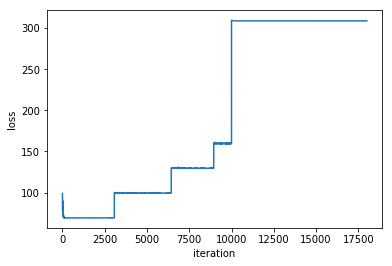

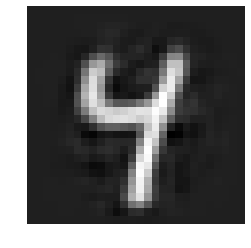

[[ 0.334898    0.12098689 -0.254813    1.5617273   0.59713197  0.25456294
   1.2614629   1.5862247 ]]
hessian postive definite
progress in % 20.0
lrate 0.1
iter 0 loss 76.5779 inverse T 0.2
iter 1000 loss 70.86722 inverse T 0.2
iter 2000 loss 70.8645 inverse T 0.2
iter 3000 loss 69.19501 inverse T 0.2
iter 4000 loss 99.59671 inverse T 0.3
iter 5000 loss 99.40489 inverse T 0.3
iter 6000 loss 99.43977 inverse T 0.3
iter 7000 loss 129.53502 inverse T 0.4
iter 8000 loss 129.71455 inverse T 0.4
iter 9000 loss 159.80113 inverse T 0.5
lrate 0.01
iter 0 loss 309.72626 inverse T 1.0
iter 1000 loss 308.6908 inverse T 1.0
iter 2000 loss 308.69363 inverse T 1.0
iter 3000 loss 308.69327 inverse T 1.0
iter 4000 loss 308.6909 inverse T 1.0
lrate 0.001
iter 0 loss 308.6979 inverse T 1.0
iter 1000 loss 308.68723 inverse T 1.0
iter 2000 loss 308.68726 inverse T 1.0


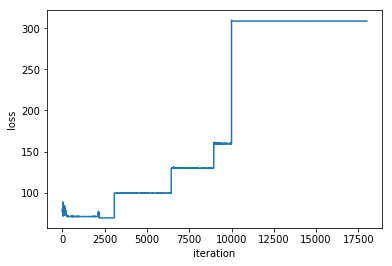

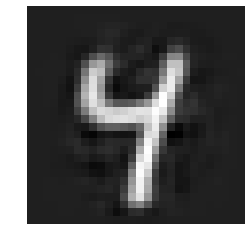

[[ 0.33487526  0.12145387 -0.2547382   1.561564    0.59741026  0.25489113
   1.2617328   1.5864192 ]]
progress in % 30.0
lrate 0.1
iter 0 loss 87.054146 inverse T 0.2
iter 1000 loss 80.009964 inverse T 0.2
iter 2000 loss 80.03792 inverse T 0.2
iter 3000 loss 80.06669 inverse T 0.2
iter 4000 loss 113.90697 inverse T 0.3
iter 5000 loss 113.784065 inverse T 0.3
iter 6000 loss 113.81385 inverse T 0.3
iter 7000 loss 147.48244 inverse T 0.4
iter 8000 loss 147.35445 inverse T 0.4
iter 9000 loss 180.80064 inverse T 0.5
lrate 0.01
iter 0 loss 348.0083 inverse T 1.0
iter 1000 loss 347.4225 inverse T 1.0
iter 2000 loss 347.43463 inverse T 1.0
iter 3000 loss 347.43634 inverse T 1.0
iter 4000 loss 347.43423 inverse T 1.0
lrate 0.001
iter 0 loss 347.4354 inverse T 1.0
iter 1000 loss 347.41296 inverse T 1.0
iter 2000 loss 347.41284 inverse T 1.0


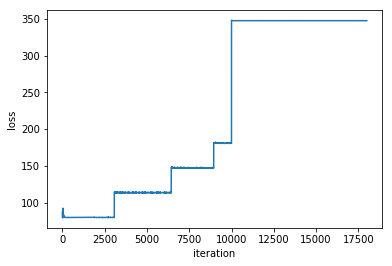

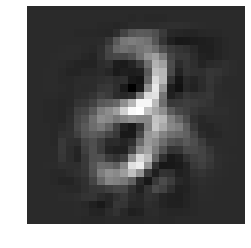

[[-0.6396269 -0.0194836 -2.583966  -0.5201661  0.6604413  0.5951988
   1.5391048 -1.8047099]]
progress in % 40.0
lrate 0.1
iter 0 loss 76.255844 inverse T 0.2
iter 1000 loss 69.51859 inverse T 0.2
iter 2000 loss 69.48601 inverse T 0.2
iter 3000 loss 69.55594 inverse T 0.2
iter 4000 loss 99.41229 inverse T 0.3
iter 5000 loss 99.40271 inverse T 0.3
iter 6000 loss 99.44613 inverse T 0.3
iter 7000 loss 129.61818 inverse T 0.4
iter 8000 loss 129.53778 inverse T 0.4
iter 9000 loss 161.01581 inverse T 0.5
lrate 0.01
iter 0 loss 309.38626 inverse T 1.0
iter 1000 loss 308.68826 inverse T 1.0
iter 2000 loss 308.69897 inverse T 1.0
iter 3000 loss 308.6949 inverse T 1.0
iter 4000 loss 308.70233 inverse T 1.0
lrate 0.001
iter 0 loss 308.69397 inverse T 1.0
iter 1000 loss 308.6872 inverse T 1.0
iter 2000 loss 308.68704 inverse T 1.0


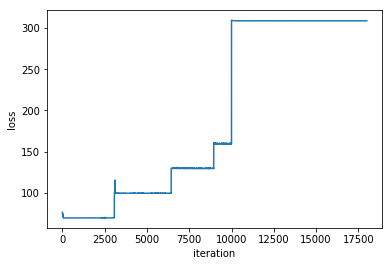

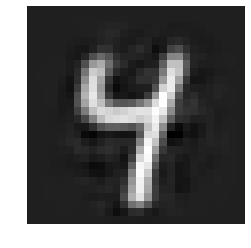

[[ 0.33453882  0.12121103 -0.2545566   1.5620176   0.59809154  0.25388035
   1.2621799   1.5864741 ]]
hessian postive definite
progress in % 50.0
lrate 0.1
iter 0 loss 93.973366 inverse T 0.2
iter 1000 loss 69.86689 inverse T 0.2
iter 2000 loss 69.86937 inverse T 0.2
iter 3000 loss 69.85982 inverse T 0.2
iter 4000 loss 108.32912 inverse T 0.3
iter 5000 loss 108.337364 inverse T 0.3
iter 6000 loss 108.3315 inverse T 0.3
iter 7000 loss 141.54498 inverse T 0.4
iter 8000 loss 141.46303 inverse T 0.4
iter 9000 loss 174.39746 inverse T 0.5
lrate 0.01
iter 0 loss 339.2552 inverse T 1.0
iter 1000 loss 339.01572 inverse T 1.0
iter 2000 loss 339.03796 inverse T 1.0
iter 3000 loss 339.02042 inverse T 1.0
iter 4000 loss 339.0221 inverse T 1.0
lrate 0.001
iter 0 loss 339.01404 inverse T 1.0
iter 1000 loss 339.0132 inverse T 1.0
iter 2000 loss 339.01248 inverse T 1.0


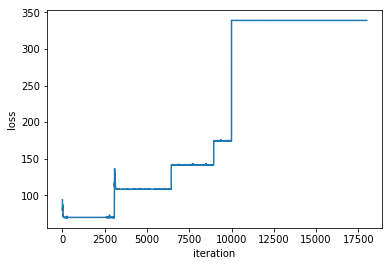

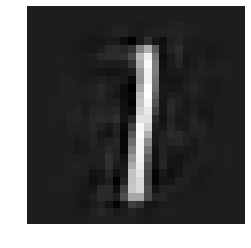

[[-1.349307   -0.4676257   0.10138354  0.1349818   0.7002461   0.66686106
   1.1216401   0.28355783]]
progress in % 60.0
lrate 0.1
iter 0 loss 85.541695 inverse T 0.2
iter 1000 loss 75.32955 inverse T 0.2
iter 2000 loss 75.65905 inverse T 0.2
iter 3000 loss 75.66018 inverse T 0.2
iter 4000 loss 108.35735 inverse T 0.3
iter 5000 loss 108.42353 inverse T 0.3
iter 6000 loss 108.42282 inverse T 0.3
iter 7000 loss 141.49364 inverse T 0.4
iter 8000 loss 141.5162 inverse T 0.4
iter 9000 loss 174.87004 inverse T 0.5
lrate 0.01
iter 0 loss 309.5568 inverse T 1.0
iter 1000 loss 308.68774 inverse T 1.0
iter 2000 loss 308.68893 inverse T 1.0
iter 3000 loss 308.69156 inverse T 1.0
iter 4000 loss 308.69785 inverse T 1.0
lrate 0.001
iter 0 loss 308.69934 inverse T 1.0
iter 1000 loss 308.68658 inverse T 1.0
iter 2000 loss 308.68698 inverse T 1.0


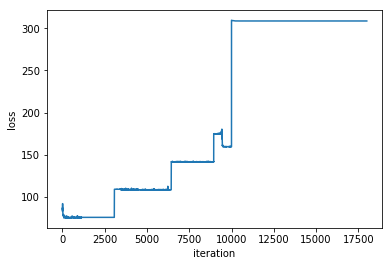

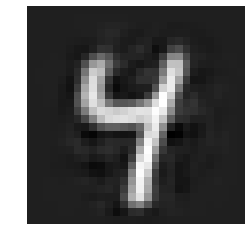

[[ 0.33452782  0.12140989 -0.25478986  1.5618714   0.5975234   0.2541321
   1.2620488   1.586224  ]]
hessian postive definite
progress in % 70.0
lrate 0.1
iter 0 loss 97.37085 inverse T 0.2
iter 1000 loss 75.67157 inverse T 0.2
iter 2000 loss 75.6612 inverse T 0.2
iter 3000 loss 75.75417 inverse T 0.2
iter 4000 loss 108.80582 inverse T 0.3
iter 5000 loss 108.67296 inverse T 0.3
iter 6000 loss 108.991005 inverse T 0.3
iter 7000 loss 141.66724 inverse T 0.4
iter 8000 loss 141.35849 inverse T 0.4
iter 9000 loss 174.45642 inverse T 0.5
lrate 0.01
iter 0 loss 339.84875 inverse T 1.0
iter 1000 loss 339.03064 inverse T 1.0
iter 2000 loss 339.02002 inverse T 1.0
iter 3000 loss 339.017 inverse T 1.0
iter 4000 loss 339.04834 inverse T 1.0
lrate 0.001
iter 0 loss 339.02283 inverse T 1.0
iter 1000 loss 339.01273 inverse T 1.0
iter 2000 loss 339.01288 inverse T 1.0


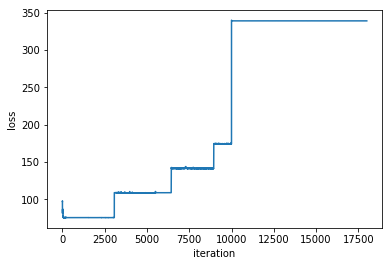

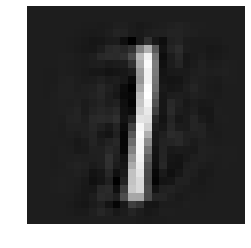

[[-1.3493187  -0.4673698   0.10354424  0.13700353  0.6999326   0.66694605
   1.1217673   0.2836983 ]]
hessian postive definite
progress in % 80.0
lrate 0.1
iter 0 loss 96.79867 inverse T 0.2
iter 1000 loss 72.99156 inverse T 0.2
iter 2000 loss 72.87279 inverse T 0.2
iter 3000 loss 72.63613 inverse T 0.2
iter 4000 loss 101.416565 inverse T 0.3
iter 5000 loss 101.08268 inverse T 0.3
iter 6000 loss 101.170135 inverse T 0.3
iter 7000 loss 131.60916 inverse T 0.4
iter 8000 loss 131.8724 inverse T 0.4
iter 9000 loss 162.4173 inverse T 0.5
lrate 0.01
iter 0 loss 313.77356 inverse T 1.0
iter 1000 loss 313.59927 inverse T 1.0
iter 2000 loss 313.5987 inverse T 1.0
iter 3000 loss 313.57764 inverse T 1.0
iter 4000 loss 313.61353 inverse T 1.0
lrate 0.001
iter 0 loss 313.59863 inverse T 1.0
iter 1000 loss 313.5717 inverse T 1.0
iter 2000 loss 313.57135 inverse T 1.0


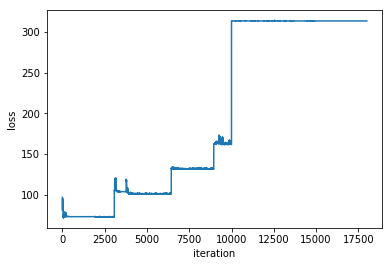

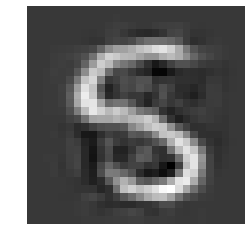

[[-0.33652794 -0.19653018  0.7732085   0.5241402  -1.1506416   0.23509206
  -1.589493   -0.37363693]]
hessian postive definite
progress in % 90.0
lrate 0.1
iter 0 loss 74.9698 inverse T 0.2
iter 1000 loss 69.19778 inverse T 0.2
iter 2000 loss 69.19983 inverse T 0.2
iter 3000 loss 69.210335 inverse T 0.2
iter 4000 loss 99.454704 inverse T 0.3
iter 5000 loss 99.46315 inverse T 0.3
iter 6000 loss 99.41521 inverse T 0.3
iter 7000 loss 129.5606 inverse T 0.4
iter 8000 loss 129.61626 inverse T 0.4
iter 9000 loss 159.84567 inverse T 0.5
lrate 0.01
iter 0 loss 309.48795 inverse T 1.0
iter 1000 loss 308.69815 inverse T 1.0
iter 2000 loss 308.6953 inverse T 1.0
iter 3000 loss 308.6887 inverse T 1.0
iter 4000 loss 308.69235 inverse T 1.0
lrate 0.001
iter 0 loss 308.69116 inverse T 1.0
iter 1000 loss 308.68655 inverse T 1.0
iter 2000 loss 308.68704 inverse T 1.0


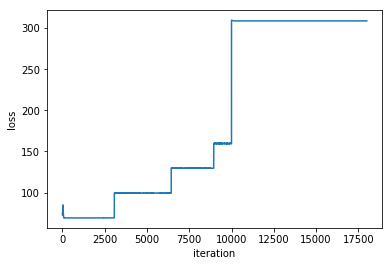

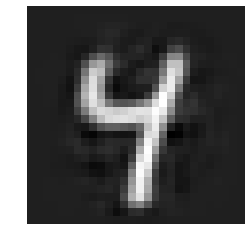

[[ 0.33478034  0.12155146 -0.25471905  1.5618459   0.596994    0.25432584
   1.2616581   1.5862664 ]]
hessian postive definite


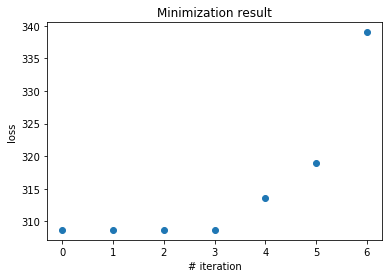

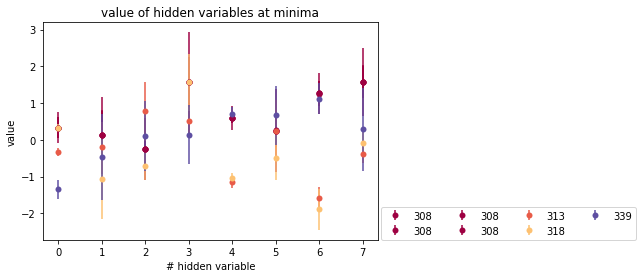

total chi2 of lowest minimum 413.0 on 392.0 pixels


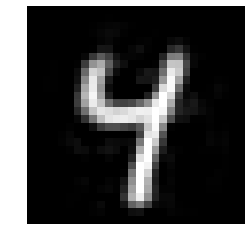

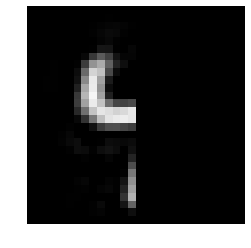

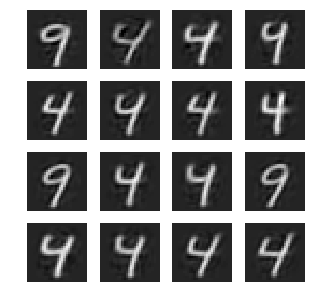

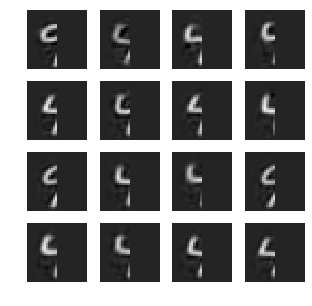

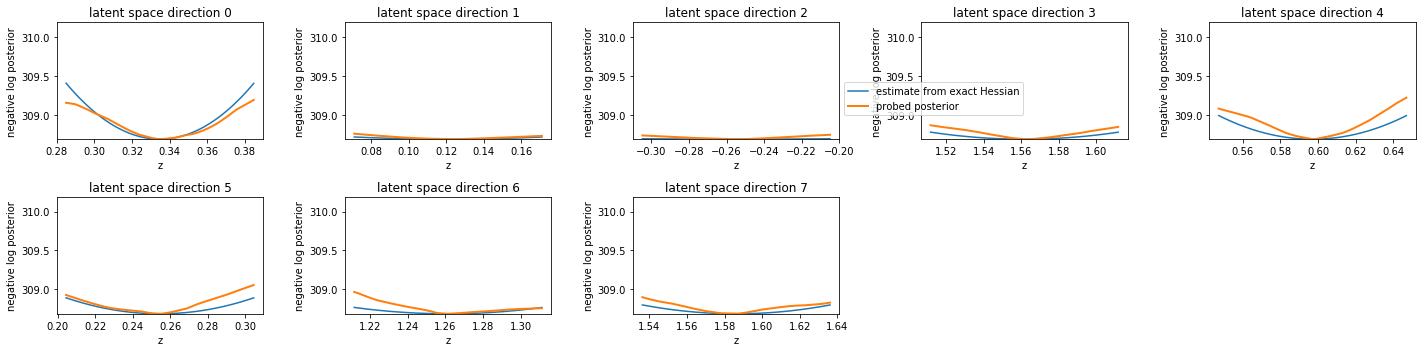

weights of Gaussian mixtures: [[9.9979848e-01]
 [2.0152422e-04]]


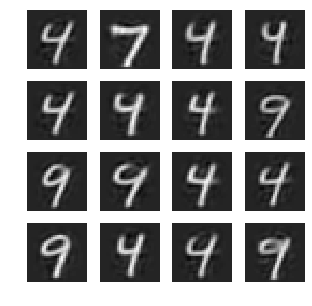

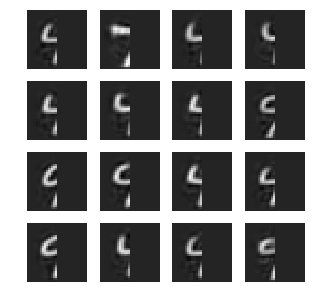

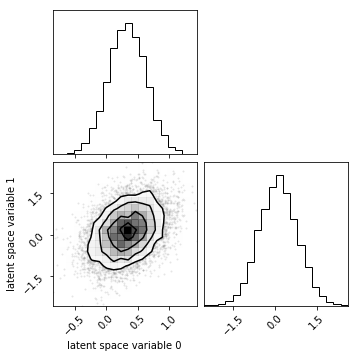

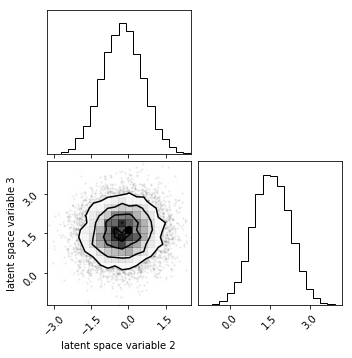

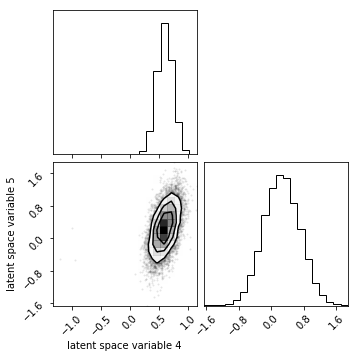

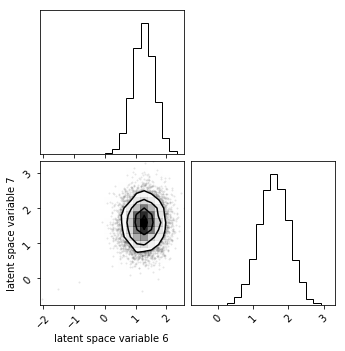

In [20]:
if __name__ == "__main__":
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  
  
  truth = x_test[num_mnist:num_mnist+data_size]
  plot_image(truth, directory=plot_path, filename='truth_%s'%label, title='truth')
  
  data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
  plot_image(data, directory=plot_path, filename='input_data_%s'%label, title='data')
  plot_image(custom_mask, directory=plot_path, filename='mask_data_%s'%label, title='mask')
  
  noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)
  plot_image(noise, directory=plot_path, filename='noise_%s'%label, title='noise')
  
  
  tf.random.set_random_seed(seed)
  inits = get_random_start_values(10, sess)
  
  try:
    minima, min_loss, min_var, recons = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))
  except:
  
    minima  =[]
    min_loss=[]
    min_var =[]
    recons  =[]
    for jj,init in enumerate(inits):
      print('progress in %', jj/len(inits)*100)
      min_z, min_l, pos_def    = minimize_posterior(init, data,custom_mask,noise,sess)
      rec                      = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
      var                      = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  
      plot_image(rec, directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
      print(min_z)
      if pos_def:
        print('hessian postive definite')
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)
    
    order    = np.argsort(min_loss)
    min_loss = np.asarray(min_loss)[order]
    minima   = np.asarray(minima)[order]
    min_var  = np.asarray(min_var)[order]
    
    pickle.dump([minima, min_loss, min_var,recons],open(minima_path+'minima_%s.pkl'%label,'wb'))

  plot_minima(minima, min_loss, min_var)

  
  chi2s = get_chi2(noise,data,recons[0],masking=True, mask=custom_mask)
  
  
  print('total chi2 of lowest minimum', '%.1f'%chi2s[0], 'on', '%.1f'%chi2s[1] ,'pixels')
  try:
    print('chi2 of lowest minimum, low pixel amplitude regions', '%.1f'%chi2s[2], 'on', '%.1f'%chi2s[3], 'pixels')
    print('chi2 of lowest minimum, high pixel amplitude regions', '%.1f'%chi2s[4], 'on', '%.1f'%chi2s[5], 'pixels')
  except:
    pass
  
  lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})
  rec     = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plot_image(rec, directory=plot_path, filename='lowest_minimum_%s_masked'%(label), title='masked reconstruction', vmin=0, vmax=1, mask = custom_mask)
  samples = get_laplace_sample(16,minima[0],data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)
  
  
  probe_posterior(minima[0], data, noise, custom_mask, sess)
  
  mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[4]], data, noise, custom_mask, min_loss[0])
  _ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })
  
  samples = get_gmm_sample(16,data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s'%label)
  
  more_samples = []
  for ii in range(10000):
    more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
  more_samples=np.asarray(more_samples)
  
  for indices in [[0,1],[2,3],[4,5],[6,7]]:
    plot_prob_2D_GMM(more_samples, indices)
  